In [17]:
import pandas as pd
import polars as pl
import numpy as np

amz_uk_df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [4]:
amz_uk_df.describe()

,uid,stars,reviews,price,boughtInLastMonth
count,2.443651e+06,2.443651e+06,2.443651e+06,2.443651e+06,2.443651e+06
mean,1.370545e+06,2.152836e+00,4.806278e+02,8.924381e+01,2.589699e+01
std,8.160562e+05,2.194865e+00,5.944124e+03,3.456089e+02,2.404837e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.589215e+05,0.000000e+00,0.000000e+00,9.990000e+00,0.000000e+00
50%,1.349029e+06,0.000000e+00,0.000000e+00,1.909000e+01,0.000000e+00
75%,2.060686e+06,4.400000e+00,5.900000e+01,4.599000e+01,0.000000e+00
max,2.828593e+06,5.000000e+00,1.356658e+06,1.000000e+05,5.000000e+04


In [5]:
amz_uk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2443651 entries, 0 to 2443650
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   uid                int64  
 1   asin               object 
 2   title              object 
 3   stars              float64
 4   reviews            int64  
 5   price              float64
 6   isBestSeller       bool   
 7   boughtInLastMonth  int64  
 8   category           object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 151.5+ MB


Create a crosstab between the product category and the isBestSeller status.


In [6]:
# Generating a crosstab for 'category' and 'isBestSeller'
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


Are there categories where being a best-seller is more prevalent?

In [9]:
# Ensure best-seller column is numeric (0/1)
amz_uk_df['isBestSeller'] = amz_uk_df['isBestSeller'].astype(int)

# Calculate proportion of best-sellers per category
best_seller_proportion = (
    amz_uk_df.groupby('category')['isBestSeller']
      .mean()
      .sort_values(ascending=False)
)

print(best_seller_proportion)

category
Grocery                             0.058135
Smart Home Security & Lighting      0.057692
Health & Personal Care              0.057686
Mobile Phone Accessories            0.042471
Power & Hand Tools                  0.035339
                                      ...   
CD, Disc & Tape Players             0.000000
General Music-Making Accessories    0.000000
Snowboard Boots                     0.000000
Boxes & Organisers                  0.000000
eBook Readers & Accessories         0.000000
Name: isBestSeller, Length: 296, dtype: float64


Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

In [12]:
from scipy.stats import chi2_contingency

In [13]:
chi2, p_value, dof, expected = chi2_contingency(crosstab_result)

In [14]:
print(f"Chi-square statistic: {chi2:.2f}")

Chi-square statistic: 36540.20


In [ ]:
# the null hypothesis of the chi test is that the best-seller distribution is independent of the product category. 
# With a p-value being 0.0 we can reject that hypothesis. That implies that there is a significant association between best-sellers and product categories

Compute Cramér's V to understand the strength of association between best-seller status and category.


In [23]:
from scipy.stats.contingency import association
association(crosstab_result, method="cramer")

0.1222829439760564

In [18]:
n = crosstab_result.values.sum()
r, k = crosstab_result.shape

cramers_v = np.sqrt(chi2 / (n * (min(r, k) - 1)))
print(f"Cramér's V: {cramers_v:.3f}")

Cramér's V: 0.122


In [ ]:
#The Cramér's V value of 0.148 suggests a weak association between the two variables. 
#Though statistically significant, the strength of this relationship is not very strong in practical terms.

Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

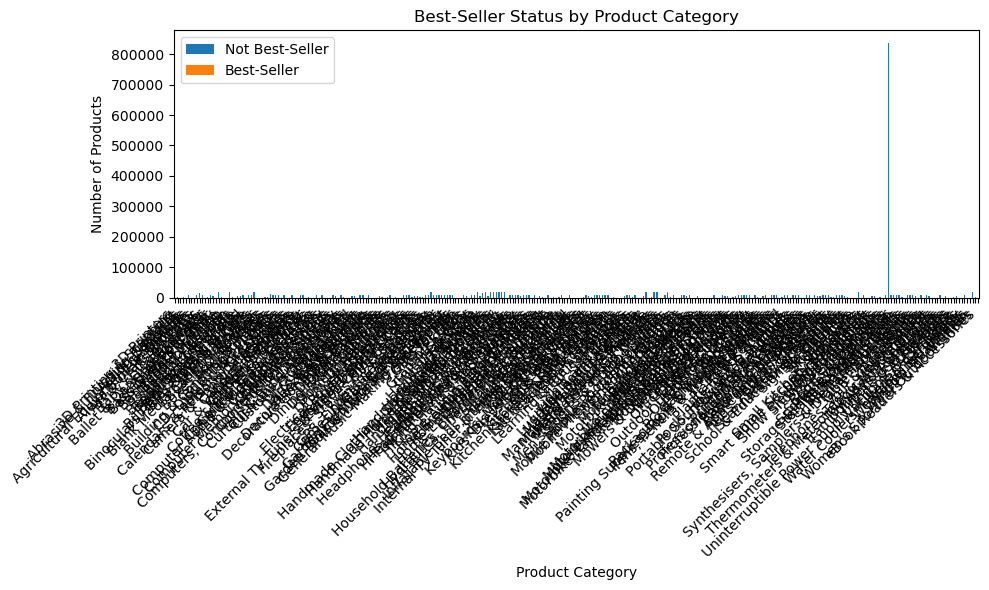

In [21]:
import matplotlib.pyplot as plt

crosstab_result.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)

plt.xlabel('Product Category')
plt.ylabel('Number of Products')
plt.title('Best-Seller Status by Product Category')
plt.legend(['Not Best-Seller', 'Best-Seller'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

Violin Plots:

Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
Which product category tends to have the highest median price? Don't filter here by top categories.
Bar Charts:

Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
Which product category commands the highest average price? Don't filter here by top categories.
Box Plots:

Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
Which category tends to receive the highest median rating from customers? Don't filter here by top categories.


In [24]:
q1 = amz_uk_df["price"].quantile(0.25)
q3 = amz_uk_df["price"].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
mask = amz_uk_df["price"].between(lower, upper)
amazon_df = amz_uk_df.loc[mask].copy()
amz_uk_df.head(10)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
5,6,B09B97WSLF,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
6,7,B09B9615X2,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
7,8,B01MTB55WH,Anker Soundcore 2 Portable Bluetooth Speaker w...,4.7,103673,39.99,False,0,Hi-Fi Speakers
8,9,B016MO90GW,"Bluetooth Speaker, Anker Soundcore Speaker Upg...",4.7,29909,29.99,False,0,Hi-Fi Speakers
9,10,B09ZQF5GZW,RIENOK Bluetooth Speaker Portable Wireless Blu...,4.5,16014,29.99,False,0,Hi-Fi Speakers


In [25]:
# Get top 20 categories by count
top_20_categories = df['category'].value_counts().head(20).index

# Filter dataframe for visualization
df_top20 = df[df['category'].isin(top_20_categories)]

<Axes: xlabel='category', ylabel='price'>

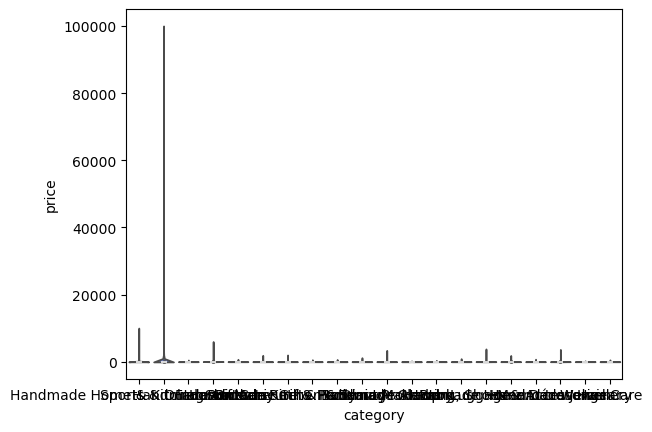

In [29]:
import seaborn as sns
sns.violinplot(data=df_top20, x='category', y='price', palette="coolwarm", hue='category', legend=False)

In [30]:
# Top 10 categories by number of products
top_10_categories = df['category'].value_counts().head(10).index

# Filter data for visualization
df_top10 = df[df['category'].isin(top_10_categories)]

In [31]:
avg_price_top10 = (
    df_top10.groupby('category')['price']
    .mean()
    .sort_values(ascending=False)
)

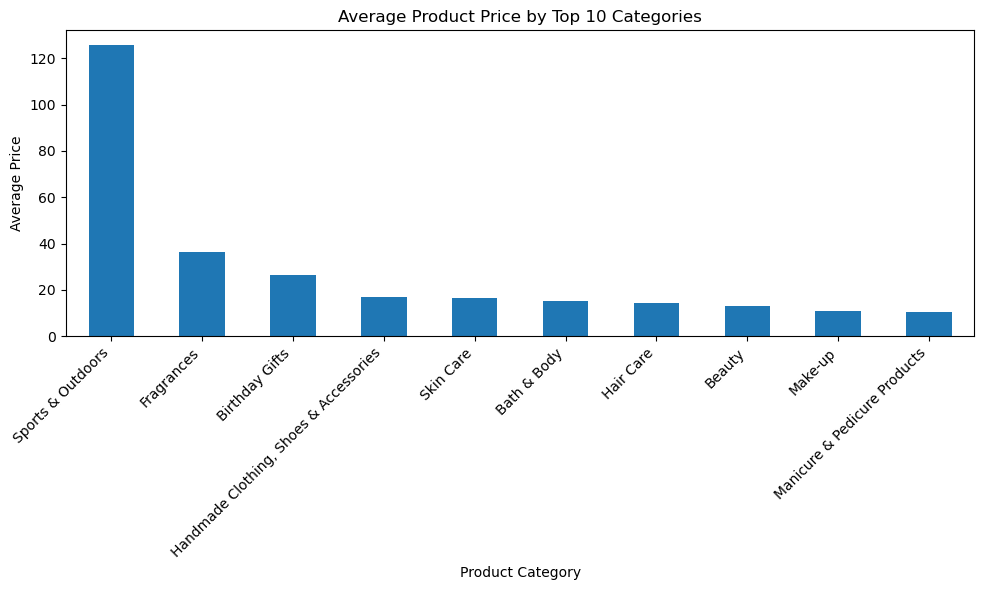

In [32]:
plt.figure(figsize=(10, 6))
avg_price_top10.plot(kind='bar')
plt.xlabel('Product Category')
plt.ylabel('Average Price')
plt.title('Average Product Price by Top 10 Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
avg_price_all = (
    df.groupby('category')['price']
    .mean()
    .sort_values(ascending=False)
)

highest_avg_category = avg_price_all.index[0]
highest_avg_price = avg_price_all.iloc[0]

print(f"Category with highest average price: {highest_avg_category}")
print(f"Average price: {highest_avg_price:.2f}")

Category with highest average price: Laptops
Average price: 1087.99


The bar chart shows clear differences in average prices among the most frequently listed product categories. Some categories consistently command higher prices than others, indicating variations in product value and market positioning.

Across all categories, {highest_avg_category} has the highest average product price, suggesting that products in this category are generally more expensive than those in others.

In [34]:
# Top 10 categories by product count
top_10_categories = df['category'].value_counts().head(10).index

# Filter dataframe for visualization
df_top10 = df[df['category'].isin(top_10_categories)]

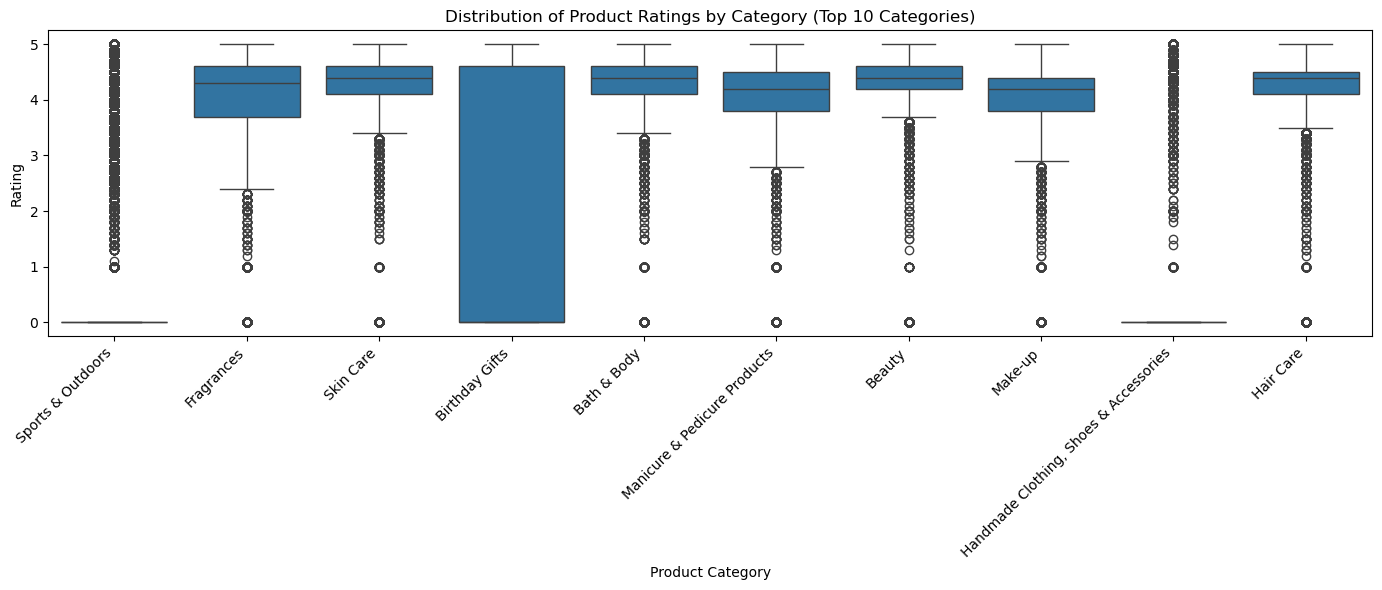

In [35]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_top10,
    x='category',
    y='stars'
)

plt.xlabel('Product Category')
plt.ylabel('Rating')
plt.title('Distribution of Product Ratings by Category (Top 10 Categories)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
median_ratings = (
    df.groupby('category')['stars']
      .median()
      .sort_values(ascending=False)
)

highest_median_category = median_ratings.index[0]
highest_median_rating = median_ratings.iloc[0]

print(f"Category with highest median rating: {highest_median_category}")
print(f"Median rating: {highest_median_rating}")

Category with highest median rating: Computer Memory
Median rating: 4.7


Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

Correlation Coefficients:

Calculate the correlation coefficient between price and stars.
Is there a significant correlation between product price and its rating?
Visualizations:

Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
Use a correlation heatmap to visualize correlations between all numerical variables.
Examine if product prices typically follow a normal distribution using a QQ plot.

In [37]:
correlation = df['price'].corr(df['stars'])
print(f"Correlation coefficient (price vs stars): {correlation:.3f}")

Correlation coefficient (price vs stars): -0.125


In [38]:
rated_df = df[df['stars'] > 0]

correlation_rated = rated_df['price'].corr(rated_df['stars'])
print(f"Correlation (rated products only): {correlation_rated:.3f}")

Correlation (rated products only): -0.005


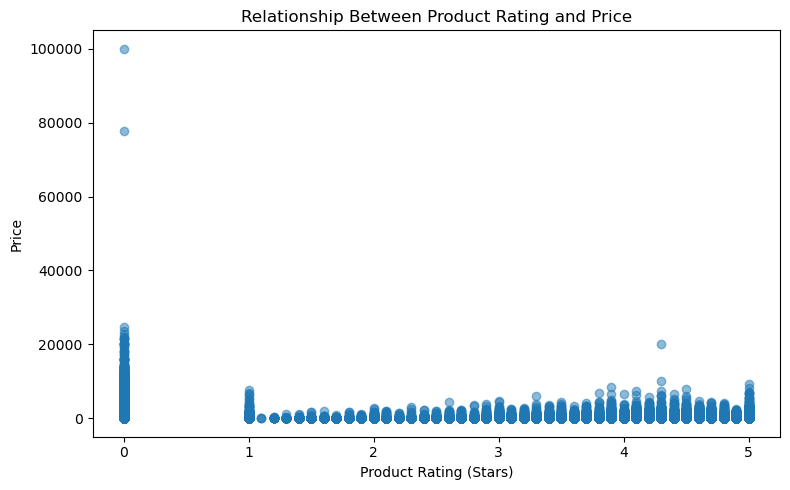

In [39]:
plt.figure(figsize=(8, 5))
plt.scatter(df['stars'], df['price'], alpha=0.5)
plt.xlabel('Product Rating (Stars)')
plt.ylabel('Price')
plt.title('Relationship Between Product Rating and Price')
plt.tight_layout()
plt.show()

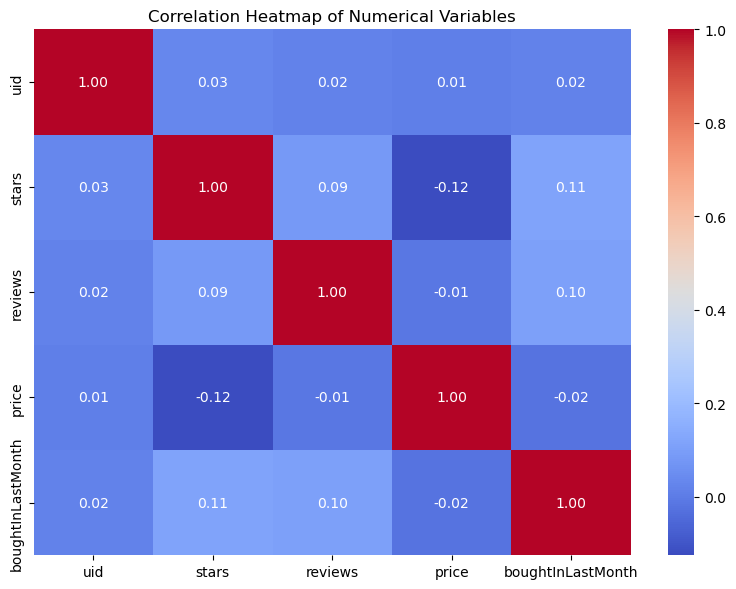

In [40]:
# Select numerical columns
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation matrix
corr_matrix = numerical_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Variables')
plt.tight_layout()
plt.show()

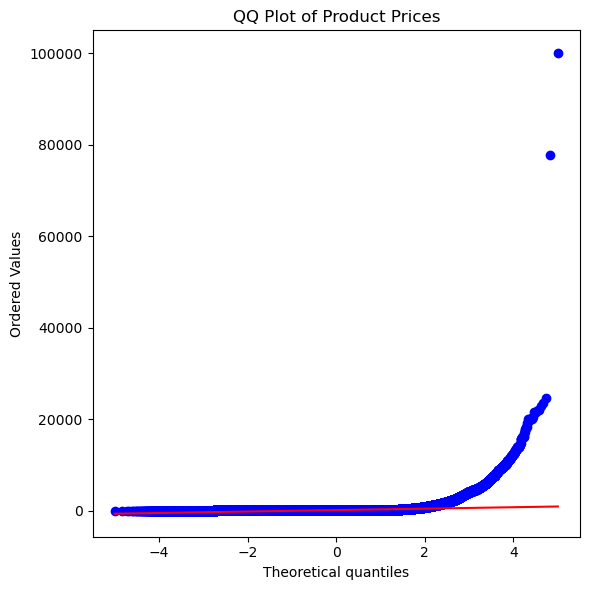

In [41]:
import scipy.stats as stats

plt.figure(figsize=(6, 6))
stats.probplot(df['price'], dist="norm", plot=plt)
plt.title('QQ Plot of Product Prices')
plt.tight_layout()
plt.show()

The scatter plot shows no strong relationship between product rating and price, with prices varying widely across all rating levels. The correlation heatmap confirms weak correlations among numerical variables, particularly between price and rating. The QQ plot demonstrates that product prices do not follow a normal distribution, instead showing strong right skewness due to high-priced outliers.